In [1]:
import numpy as np, matplotlib.pyplot as plt, random, time, datetime
from functools import lru_cache
from pyquil import Program, get_qc
from pyquil.gates import *
import os, sys
from pyquil.quilatom import quil_sin, quil_cos, Parameter
from pyquil.quilbase import DefGate
from pyquil.latex import display, to_latex
# import Peres_helpers as hf
import pickle
from collections import Counter
from scipy.optimize import curve_fit as cf
sys.path.append('binomial_cython')
from binomial import binomial_dist

N_SHOTS = 10_000
Z_SCORE = 3

# Theoretical probabilities
def p12(t1, f1, t2, f2):
    res = np.cos(t1/2)*np.cos(t2/2)*np.exp(-1j*(f1+f2)/2)
    res += np.cos(t1/2)*np.sin(t2/2)*np.exp(1j*(f2-f1)/2)
    res = np.linalg.norm(res)
    res = res**2/2

    return res

def p23(t1, f1, t2, f2):
    res = np.cos(t1/2)*np.sin(t2/2)*np.exp(1j*(f2-f1)/2)
    res += np.sin(t1/2)*np.cos(t2/2)*np.exp(-1j*(f2-f1)/2)
    res = np.linalg.norm(res)
    res = res**2/2

    return res

def p31(t1, f1, t2, f2):
    res = np.cos(t1/2)*np.cos(t2/2)*np.exp(-1j*(f1+f2)/2)
    res += np.sin(t1/2)*np.cos(t2/2)*np.exp(-1j*(f2-f1)/2)
    res = np.linalg.norm(res)
    res = res**2/2

    return res

def p1(t1, f1, t2, f2):
    return (np.cos(t1/2)*np.cos(t2/2))**2

def p2(t1, f1, t2, f2):
    return (np.cos(t1/2)*np.sin(t2/2))**2

def p3(t1, f1, t2, f2):
    return (np.sin(t1/2)*np.cos(t2/2))**2

def p4(t1, f1, t2, f2):
    return (np.sin(t1/2)*np.sin(t2/2))**2

def p123(t1, f1, t2, f2):
    res = np.cos(t1/2)*np.cos(t2/2)*np.exp(-1j*(f1+f2)/2)
    res += np.cos(t1/2)*np.sin(t2/2)*np.exp(1j*(f2-f1)/2)
    res += np.sin(t1/2)*np.cos(t2/2)*np.exp(-1j*(f2-f1)/2)

    res = np.linalg.norm(res)
    res = res**2/3

    return res

# The circuit for constructing the product state and measuring in Bell basis.
def circuit(qubit1, qubit2, config):
    '''
    Constructs the quantum circuit and returns it.
    
    Input:
    qubit1: The id of qubit1
    qubit2: The id of qubit2
    config: Config is a string which states which basis to project the given state on. 
            It is a 4-digit binary number 'XXXX', where the left-most digit corresponds to '00'
            and as we proceed towards the right it refers to '01', '10' and '11' in that order.
            For example, if we want to project the state on 00+01 then the config will be '1100'.
    
    Output: PyQuil circuit object 'circ'
    '''
    # Initialising a pyquil circuit object
    circ = Program()
    
    # Declaring variables for parametric compilation
    c = circ.declare('ro', 'BIT', 2) # Stores the measurement outcomes.
    theta = circ.declare('theta', 'REAL', 2) # The theta values for Ry gates to construct states
    phi = circ.declare('phi', 'REAL', 2) # The phi values for Rz gates to construct states
    
    # Preparation of states.
    # State in qubit 1
    circ += RY(theta[0], qubit1)
    circ += RZ(phi[0], qubit1)
    
    # State in qubit 2
    circ += RY(theta[1], qubit2)
    circ += RZ(phi[1], qubit2)
    
    # Different measurement bases
    # For 00 + 01
    if config == '1100':
        circ += H(qubit2)
        
    # For 01 + 10
    elif config == '0110':
        circ += X(qubit1)
        circ += CNOT(qubit1, qubit2)
        circ += H(qubit1)
        
    # For 00 + 10
    elif config == '1010':
        circ += H(qubit1)
        
    # For 00 + 01 + 10
    elif config == '1110':
        circ += X(qubit1)
        circ += RY(-np.arccos(1/np.sqrt(2)), qubit2)
        circ += CNOT(qubit1, qubit2)
        circ += RY(np.arccos(1/np.sqrt(2)), qubit2)
        circ += CNOT(qubit1, qubit2)
        circ += RY(-2*np.arccos(1/np.sqrt(3)), qubit1)

    # Measuring the qubits and storing them in c-register
    circ += MEASURE(qubit1, c[0])
    circ += MEASURE(qubit2, c[1])
    
    # Repeat the circuit N_SHOTS times (Here it is 10,000 times)
    circ.wrap_in_numshots_loop(N_SHOTS)
    
    # Return the constructed circuit.
    return circ

def params_complex():
	'''
	Generates parameters to prepare COMPLEX quantum states.
    
    Input: Nothing
    
    Output: A list of two tuples of (theta, phi)
	'''
    # Generate two random theta values
	theta = np.arccos(1 - 2 * np.array([random.uniform(0,1) for _ in range(2)]))
    
    # Generate two random phi values
	phi = np.array([2*np.pi*random.uniform(0,1) for _ in range(2)])
    
    # Zip them into tuples for organisation
	params = zip(theta, phi)
	return list(params)

def get_good_qbits(cz_fid, meas_fid):
    '''
    Finds the best pair of qubits given the lower-bound on the fidelities of CZ and MEASURE operation.
    
    Input: 
    cz_fid: The lower-bound on fidelity of CZ gate
    meas_fid: The lower-bound on fidelity of MEASURE operation
    
    Output:
    good_qubits: A list of good qubits with details of fidelities.
    
    '''
    # Initialise Aspen-9 machine
    qc = get_qc('Aspen-9')
    
    # Get the details of qubits and edges
    details = qc.device.get_isa()

    good_edges = [] # To store the details of good qubits.
    
    # Looping through all the edges to find the edge with max-fidelity CZ-gate
    for edge in details.edges:
        # Getting the list of gates supported by the edge
        gates = edge.gates
        # Looping through the list of gates
        for gate in gates:
            # Picking the CZ gate
            if gate.operator == 'CZ':
                # Checking if the gate-fidelity is above the threshold.
                # The try-except statement will prevent the program from terminating if CZ is not supported by the edge.
                try:
                    if gate.fidelity > cz_fid:
                        good_edges.append(edge)
                except TypeError:
                    continue
    good_qubits = {} # A dictionary to store the details of good qubits in organised form
    
    # Looping through the list of good edges to pick the ones with qubits with MEASURE-fidelity above the threshold.
    for edge in good_edges[:]:
        # Getting the qubit objects from the edge object so that we check only those qubits for which the edge satisfies the condition
        q1, q2 = edge.targets
        # Looping through the list of qubits available
        for q in details.qubits:
            # Checking if the qubit is present in the list of good edges
            if q.id in [q1,q2]:
                # Getting the list of gates supported by the chosen qubit
                gates = q.gates
                # Looping through the list of gates.
                for gate in gates:
                    # Picking the MEASURE gate
                    if gate.operator == 'MEASURE':
                        # Checking if the measure-fidelity is below the threshold.
                        # If yes, then the corresponding edge is removed from the list of good edges, leaving only the good-qubit-edges.
                        if gate.fidelity < meas_fid:
                            try:
                                good_edges.remove(edge)
                            except ValueError:
#                                 print('Edge already removed')
                                continue
    good_qubits = [] # To store the good qubits with details.
    
    # Looping through the list of good-edges
    for edge in good_edges:
        # Getting the target qubits of the corresponding edge
        q1, q2 = edge.targets
        # Storing the details of the edge in dictionary form.
        good_qubits.append({'Edge': edge})
        
        # Storing the details of the qubits in dictionary form.
        for q in details.qubits:
            if q.id == q1:
                good_qubits[-1]['Qubit1'] = q
            elif q.id == q2:
                good_qubits[-1]['Qubit2'] = q
    return good_qubits

In [36]:
# num_states = 10
# states = [params_complex() for _ in range(num_states)]#[[(np.pi/4, np.pi), (np.pi/8, np.pi/2)]]

data = []
counter = 1
for state in states:
    t1, f1 = state['State_params'][0]
    t2, f2 = state['State_params'][1]
    g12_list, g23_list, g31_list, f_list, k_list = [], [], [], [], []
    for i in range(1000):
        counts_12 = Counter(random.choices(['0', '1'], weights=[p12(t1,f1,t2,f2), 1-p12(t1,f1,t2,f2)], k=10_000))
        counts_23 = Counter(random.choices(['0', '1'], weights=[p23(t1,f1,t2,f2), 1-p23(t1,f1,t2,f2)], k=10_000))
        counts_31 = Counter(random.choices(['0', '1'], weights=[p31(t1,f1,t2,f2), 1-p31(t1,f1,t2,f2)], k=10_000))
        counts_singles = Counter(random.choices(['0', '1', '2', '4'], weights=[p1(t1,f1,t2,f2), p2(t1,f1,t2,f2), p3(t1,f1,t2,f2), p4(t1,f1,t2,f2)], k=10_000))
        counts_123 = Counter(random.choices(['0', '1'], weights=[p123(t1,f1,t2,f2), 1-p123(t1,f1,t2,f2)], k=10_000))

        if 0 in [counts_singles['0'], counts_singles['1'], counts_singles['2']]:
            print("Division by zero encountered. Ignoring this point.")
            continue
        g12 = (2*counts_12['0'] - counts_singles['0'] - counts_singles['1']) / (2 * np.sqrt(counts_singles['0']*counts_singles['1']))
        g23 = (2*counts_23['0'] - counts_singles['1'] - counts_singles['2']) / (2 * np.sqrt(counts_singles['1']*counts_singles['2']))
        g31 = (2*counts_31['0'] - counts_singles['2'] - counts_singles['0']) / (2 * np.sqrt(counts_singles['2']*counts_singles['0']))
        f = g12**2 + g23**2 + g31**2 - 2*g12*g23*g31
        k = 3 * counts_123['0'] - 2 * (counts_12['0']+counts_23['0']+counts_31['0']) + (counts_singles['0']+counts_singles['1']+counts_singles['2'])
        k = k / 10_000
        
        g12_list.append(g12)
        g23_list.append(g23)
        g31_list.append(g31)
        f_list.append(f)
        k_list.append(k)

    g12_list.sort()
    g23_list.sort()
    g31_list.sort()
    f_list.sort()
    k_list.sort()

    g12_mean = np.mean(g12_list)
    g23_mean = np.mean(g23_list)
    g31_mean = np.mean(g31_list)
    f_mean = np.mean(f_list)
    k_mean = np.mean(k_list)

    g12_ci = [g12_list[int(0.005*len(g12_list))], g12_list[int(0.995*len(g12_list))]]
    g23_ci = [g23_list[int(0.005*len(g23_list))], g23_list[int(0.995*len(g23_list))]]
    g31_ci = [g31_list[int(0.005*len(g31_list))], g31_list[int(0.995*len(g31_list))]]
    f_ci = [f_list[int(0.005*len(f_list))], f_list[int(0.995*len(f_list))]]
    k_ci = [k_list[int(0.005*len(k_list))], k_list[int(0.995*len(k_list))]]


#     data_instance = {'State_params': state}
#     data_instance['Theory'] = {'g12': {'val': g12_mean, 'ci': g12_ci}, 'g23': {'val': g23_mean, 'ci': g23_ci}, 'g31': {'val': g31_mean, 'ci': g31_ci}, 'f': {'val': f_mean, 'ci': f_ci}, 'k': {'val': k_mean, 'ci': k_ci}}
    state['Theory'] = {'g12': {'val': g12_mean, 'ci': g12_ci}, 'g23': {'val': g23_mean, 'ci': g23_ci}, 'g31': {'val': g31_mean, 'ci': g31_ci}, 'f': {'val': f_mean, 'ci': f_ci}, 'k': {'val': k_mean, 'ci': k_ci}}
        

#     data.append(data_instance)

    print(f'Done with state no.: {counter}', end='\r')
    counter += 1

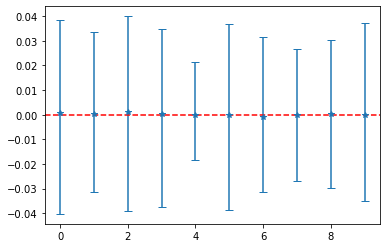

In [24]:
# fs = np.array([data[i]['Theory']['k']['val'] for i in range(len(data))])
# fci = np.array([data[i]['Theory']['k']['ci'] for i in range(len(data))])

# x = np.arange(len(data))

# plt.errorbar(x, fs, yerr=[fs - fci[:,0], fci[:,1] - fs], marker='*', ls='', capsize=4)
# plt.axhline(y=0, ls='dashed', color='red')
# # plt.axhline(y=-1, ls='dashed', color='red')
# plt.show()

In [78]:
with open('states_with_theory_values_set_1.pkl', 'rb') as file:
    states = pickle.load(file)

In [79]:
# Get the good qubits
good_bits = get_good_qbits(0.96, 0.96)#(0.97, 0.96)

# Displaying the details of the gate fidelities of the returned qubits.
for bits in good_bits:
    print(bits['Edge'].targets)
    print(bits['Qubit1'].gates[0])
    print(bits['Qubit2'].gates[0])
    print(bits['Edge'].gates[0], end='\n\n')
    

(23, 24)
MeasureInfo(operator='MEASURE', qubit=23, target='_', duration=2000, fidelity=0.9789999999999999)
MeasureInfo(operator='MEASURE', qubit=24, target='_', duration=2000, fidelity=0.982)
GateInfo(operator='CZ', parameters=[], arguments=['_', '_'], duration=200, fidelity=0.9762620340466897)

(32, 33)
MeasureInfo(operator='MEASURE', qubit=32, target='_', duration=2000, fidelity=0.976)
MeasureInfo(operator='MEASURE', qubit=33, target='_', duration=2000, fidelity=0.9620000000000001)
GateInfo(operator='CZ', parameters=[], arguments=['_', '_'], duration=200, fidelity=0.9675324210691539)



In [80]:
# Choose the best out of all the returned good qubits
good_qubits = good_bits[0]

In [81]:
# Details of circuit-run
q1, q2 = good_qubits['Qubit1'].id, good_qubits['Qubit2'].id # Qubit IDs
print(q1,q2)
# iters = 25 # Number of states for which to run the circuit
# states = [{'State_params': params_complex()} for _ in range(iters)] # Generating a list of random states
# with open('good_states_set_2.pkl', 'rb') as file:
#     states = pickle.load(file)

# List of configs
configs = ['1100', '0110', '1010', '1110', 'Singles']

# Details of the device on which to run the circuit
engine = 'Aspen-9' # Choosing between simulator and Aspen-9 computer
qc = get_qc(engine) # Initialising the device
print(qc) # Display device details

23 24
Aspen-9


In [84]:
trial = 5 # The trial number
# states = good_states_set_1 + good_states_set_2
i = 1
for state in states:
    params = state['State_params']
    params_split = list(map(list, list(zip(*params))))
    theta_list, phi_list = params_split[0], params_split[1]
    state[engine] = {}
    for config in configs:
        circ = circuit(q1, q2, config)
        exe = qc.compile(circ)
        
        clicks = qc.run(exe, memory_map={'theta': theta_list, 'phi': phi_list}) # Stores the output of the circuit run.
        clicks = np.array([''.join(list(map(str, elem))) for elem in clicks])
        counts = Counter(clicks)
        
#         state[engine] = {}
        state[engine][f'Clicks_{config}'] = clicks
        state[engine][f'Counts_{config}'] = counts
    print(f'Done with iteration {i}', end='\r')
    i += 1

UserMessageError: ERROR: It looks like you've tried to run a program against a QPU but do
not currently have a reservation on one. To reserve time on Rigetti
QPUs, use the command line interface, qcs, which comes pre-installed
in your QMI. From within your QMI, type:

    qcs reserve --lattice <lattice-name>

For more information, please see the docs at
https://www.rigetti.com/qcs/docs/reservations or reach out to Rigetti
support at support@rigetti.com.

In [ ]:
# with open('19_10_21_Aspen9_clicks_with_machine_details_trial_5.pkl', 'wb') as file:
#     pickle.dump([good_qubits, states], file)

In [98]:
with open('19_10_21_Aspen9_clicks_with_machine_details_trial_4.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

good_qubits = loaded_data[0]
states = loaded_data[1]

In [99]:
for state in states:
    g12 = (2*state[engine]['Counts_1100']['00'] - state[engine]['Counts_Singles']['00'] - state[engine]['Counts_Singles']['01']) / (2 * np.sqrt(state[engine]['Counts_Singles']['00'] * state[engine]['Counts_Singles']['01']))
    g23 = (2*state[engine]['Counts_0110']['00'] - state[engine]['Counts_Singles']['01'] - state[engine]['Counts_Singles']['10']) / (2 * np.sqrt(state[engine]['Counts_Singles']['01'] * state[engine]['Counts_Singles']['10']))
    g31 = (2*state[engine]['Counts_1010']['00'] - state[engine]['Counts_Singles']['10'] - state[engine]['Counts_Singles']['00']) / (2 * np.sqrt(state[engine]['Counts_Singles']['10'] * state[engine]['Counts_Singles']['00']))

    f = g12**2 + g23**2 + g31**2 - 2*g12*g23*g31
    
    k = 3*state[engine]['Counts_1110']['00'] - 2*(state[engine]['Counts_1100']['00'] + state[engine]['Counts_0110']['00'] + state[engine]['Counts_1010']['00']) + state[engine]['Counts_Singles']['00'] + state[engine]['Counts_Singles']['01'] + state[engine]['Counts_Singles']['10']
    k = k/N_SHOTS
    state[engine][f'Result'] = {'g12': {'val':g12}, 'g23': {'val':g23}, 'g31': {'val':g31}, 'f': {'val':f}, 'k': {'val':k}}

In [ ]:
with open(f'one-shot-results_with_good_states_set_2_on_{engine}_trial_{trial}.pkl', 'wb') as file:
    pickle.dump([good_qubits, states], file)

In [39]:
states[0][engine]['Result']

{'g12': {'val': 1.0892970642229487, 'ci': 0},
 'g23': {'val': 0.25513210258262414},
 'g31': {'val': 0.3320233378938992},
 'f': {'val': 1.1773516810932925},
 'k': {'val': -0.0152}}

In [41]:
# with open(f'one-shot-results_with_good_states_set_2_on_{engine}_trial_{1}.pkl', 'rb') as file:
#     loaded_data = pickle.load(file)

# states = loaded_data[1]
engine='Aspen-9'
for state in states:
    g12_boot = []
    g23_boot = []
    g31_boot = []
    f_boot = []
    k_boot = []
    for i in range(1000):
        sample_1100 = state[engine]['Clicks_1100']
        sample_0110 = state[engine]['Clicks_0110']
        sample_1010 = state[engine]['Clicks_1010']
        sample_1110 = state[engine]['Clicks_1110']
        sample_Singles = state[engine]['Clicks_Singles']

        counts_1100 = Counter(np.random.choice(sample_1100, len(sample_1100)))
        counts_0110 = Counter(np.random.choice(sample_0110, len(sample_0110)))
        counts_1010 = Counter(np.random.choice(sample_1010, len(sample_1010)))
        counts_1110 = Counter(np.random.choice(sample_1110, len(sample_1110)))
        counts_Singles = Counter(np.random.choice(sample_Singles, len(sample_Singles)))

        g12 = (2*counts_1100['00'] - counts_Singles['00'] - counts_Singles['01']) / (2 * np.sqrt(counts_Singles['00'] * counts_Singles['01']))
        g23 = (2*counts_0110['00'] - counts_Singles['01'] - counts_Singles['10']) / (2 * np.sqrt(counts_Singles['01'] * counts_Singles['10']))
        g31 = (2*counts_1010['00'] - counts_Singles['10'] - counts_Singles['00']) / (2 * np.sqrt(counts_Singles['10'] * counts_Singles['00']))


        f = g12**2 + g23**2 + g31**2 - 2*g12*g23*g31

        k = 3*counts_1110['00'] - 2*(counts_1100['00'] + counts_0110['00'] + counts_1010['00']) + counts_Singles['00'] + counts_Singles['01'] + counts_Singles['10']
        k = k/N_SHOTS

        g12_boot.append(g12)
        g23_boot.append(g23)
        g31_boot.append(g31)
        f_boot.append(f)
        k_boot.append(k)
    
    g12_boot.sort()
    g23_boot.sort()
    g31_boot.sort()
    f_boot.sort()
    k_boot.sort()
    
#     state[engine]['Result']['g12']['ci']
    
    state[engine]['Result']['g12']['ci'] = [g12_boot[int(0.005*len(g12_boot))], g12_boot[int(0.995*len(g12_boot))]]
    state[engine]['Result']['g23']['ci'] = [g23_boot[int(0.005*len(g23_boot))], g23_boot[int(0.995*len(g23_boot))]]
    state[engine]['Result']['g31']['ci'] = [g31_boot[int(0.005*len(g31_boot))], g31_boot[int(0.995*len(g31_boot))]]
    state[engine]['Result']['f']['ci'] = [f_boot[int(0.005*len(f_boot))], f_boot[int(0.995*len(f_boot))]]
    state[engine]['Result']['k']['ci'] =[k_boot[int(0.005*len(k_boot))], k_boot[int(0.995*len(k_boot))]]
    
#     state[engine]['CI'] = {'g12': g12_cf, 'g23': g23_cf, 'g31': g31_cf, 'f': f_cf, 'k': k_cf}
    
    print(f'Done with state no. {states.index(state)}', end='\r')


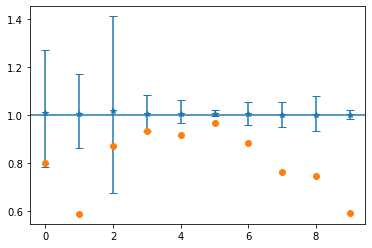

In [105]:
quant = 'f'
# states = chosen_states
fth = np.array([states[i]['Theory'][quant]['val'] for i in range(len(states))])
fthci = np.array([states[i]['Theory'][quant]['ci'] for i in range(len(states))])

# f2q = np.array([states[i]['2q-qvm']['Result'][quant]['val'] for i in range(len(states))])
# f2qci = np.array([states[i]['2q-qvm']['Result'][quant]['ci'] for i in range(len(states))])

fas = np.array([states[i]['Aspen-9']['Result'][quant]['val'] for i in range(len(states))])
# fasci = np.array([states[i]['Aspen-9']['Result'][quant]['ci'] for i in range(len(states))])

x = np.arange(len(data))

plt.errorbar(x, fth, yerr=[fth-fthci[:,0], fthci[:,1]-fth], marker="*", ls="", capsize=4)
# plt.errorbar(x, f2q, yerr=[f2q-f2qci[:,0], f2qci[:,1]-f2q], marker="o", ls="", capsize=4)
# plt.errorbar(x, fas, yerr=[fas-fasci[:,0], fasci[:,1]-fas], marker="o", ls="", capsize=4)
plt.plot(x, fas, 'o')


plt.axhline(y=1)
# plt.axhline(y=-1)
plt.show()

In [50]:
with open('good_states_set_2.pkl', 'wb') as file:
    pickle.dump(chosen_states, file)

In [22]:
states_params = [states[i]['State_params'] for i in range(len(states))]

# Fluctuations

In [1]:
import numpy as np, matplotlib.pyplot as plt
import random
from collections import Counter

def params_complex():
    '''
    Generates parameters to prepare COMPLEX quantum states.
    '''
    theta = np.arccos(1 - 2 * np.array([random.uniform(0,1) for _ in range(2)]))
    phi = np.array([2*np.pi*random.uniform(0,1) for _ in range(2)])
    params = zip(theta, phi)
    return list(params)


def p12(t1, f1, t2, f2):
    res = np.cos(t1/2)*np.cos(t2/2)*np.exp(-1j*(f1+f2)/2)
    res += np.cos(t1/2)*np.sin(t2/2)*np.exp(1j*(f2-f1)/2)
    res = np.linalg.norm(res)
    res = res**2/2

    return res

def p23(t1, f1, t2, f2):
    res = np.cos(t1/2)*np.sin(t2/2)*np.exp(1j*(f2-f1)/2)
    res += np.sin(t1/2)*np.cos(t2/2)*np.exp(-1j*(f2-f1)/2)
    res = np.linalg.norm(res)
    res = res**2/2

    return res

def p31(t1, f1, t2, f2):
    res = np.cos(t1/2)*np.cos(t2/2)*np.exp(-1j*(f1+f2)/2)
    res += np.sin(t1/2)*np.cos(t2/2)*np.exp(-1j*(f2-f1)/2)
    res = np.linalg.norm(res)
    res = res**2/2

    return res

def p1(t1, f1, t2, f2):
    return (np.cos(t1/2)*np.cos(t2/2))**2

def p2(t1, f1, t2, f2):
    return (np.cos(t1/2)*np.sin(t2/2))**2

def p3(t1, f1, t2, f2):
    return (np.sin(t1/2)*np.cos(t2/2))**2

def p4(t1, f1, t2, f2):
    return (np.sin(t1/2)*np.sin(t2/2))**2

def p123(t1, f1, t2, f2):
    res = np.cos(t1/2)*np.cos(t2/2)*np.exp(-1j*(f1+f2)/2)
    res += np.cos(t1/2)*np.sin(t2/2)*np.exp(1j*(f2-f1)/2)
    res += np.sin(t1/2)*np.cos(t2/2)*np.exp(-1j*(f2-f1)/2)

    res = np.linalg.norm(res)
    res = res**2/3

    return res

In [4]:
num_states = 10
states = [params_complex() for _ in range(num_states)]#[[(np.pi/4, np.pi), (np.pi/8, np.pi/2)]]

data = []
counter = 1
for state in states:
    t1, f1 = state[0]
    t2, f2 = state[1]
    g12_list, g23_list, g31_list, f_list, k_list = [], [], [], [], []
    for i in range(1000):
        counts_12 = Counter(random.choices(['0', '1'], weights=[p12(t1,f1,t2,f2), 1-p12(t1,f1,t2,f2)], k=10_000))
        counts_23 = Counter(random.choices(['0', '1'], weights=[p23(t1,f1,t2,f2), 1-p23(t1,f1,t2,f2)], k=10_000))
        counts_31 = Counter(random.choices(['0', '1'], weights=[p31(t1,f1,t2,f2), 1-p31(t1,f1,t2,f2)], k=10_000))
        counts_singles = Counter(random.choices(['0', '1', '2', '4'], weights=[p1(t1,f1,t2,f2), p2(t1,f1,t2,f2), p3(t1,f1,t2,f2), p4(t1,f1,t2,f2)], k=10_000))
        counts_123 = Counter(random.choices(['0', '1'], weights=[p123(t1,f1,t2,f2), 1-p123(t1,f1,t2,f2)], k=10_000))

        if 0 in [counts_singles['0'], counts_singles['1'], counts_singles['2']]:
            print("Division by zero encountered. Ignoring this point.")
            continue
        g12 = (2*counts_12['0'] - counts_singles['0'] - counts_singles['1']) / (2 * np.sqrt(counts_singles['0']*counts_singles['1']))
        g23 = (2*counts_23['0'] - counts_singles['1'] - counts_singles['2']) / (2 * np.sqrt(counts_singles['1']*counts_singles['2']))
        g31 = (2*counts_31['0'] - counts_singles['2'] - counts_singles['0']) / (2 * np.sqrt(counts_singles['2']*counts_singles['0']))
        f = g12**2 + g23**2 + g31**2 - 2*g12*g23*g31
        k = 3 * counts_123['0'] - 2 * (counts_12['0']+counts_23['0']+counts_31['0']) + (counts_singles['0']+counts_singles['1']+counts_singles['2'])
        k = k / 10_000
        
        g12_list.append(g12)
        g23_list.append(g23)
        g31_list.append(g31)
        f_list.append(f)
        k_list.append(k)

    g12_list.sort()
    g23_list.sort()
    g31_list.sort()
    f_list.sort()
    k_list.sort()

    g12_mean = np.mean(g12_list)
    g23_mean = np.mean(g23_list)
    g31_mean = np.mean(g31_list)
    f_mean = np.mean(f_list)
    k_mean = np.mean(k_list)

    g12_ci = [g12_list[int(0.025*len(g12_list))], g12_list[int(0.975*len(g12_list))]]
    g23_ci = [g23_list[int(0.025*len(g23_list))], g23_list[int(0.975*len(g23_list))]]
    g31_ci = [g31_list[int(0.025*len(g31_list))], g31_list[int(0.975*len(g31_list))]]
    f_ci = [f_list[int(0.025*len(f_list))], f_list[int(0.975*len(f_list))]]
    k_ci = [k_list[int(0.025*len(k_list))], k_list[int(0.975*len(k_list))]]


    data_instance = {'State_params': state}
    data_instance['Theory'] = {'g12': {'val': g12_mean, 'ci': g12_ci}, 'g23': {'val': g23_mean, 'ci': g23_ci}, 'g31': {'val': g31_mean, 'ci': g31_ci}, 'f': {'val': f_mean, 'ci': f_ci}, 'k': {'val': k_mean, 'ci': k_ci}}

    data.append(data_instance)

    print(f'Done with state no.: {counter}', end='\r')
    counter += 1

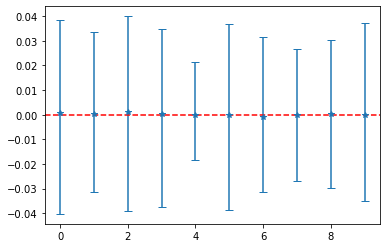

In [11]:
fs = np.array([data[i]['Theory']['k']['val'] for i in range(len(data))])
fci = np.array([data[i]['Theory']['k']['ci'] for i in range(len(data))])

x = np.arange(len(data))

plt.errorbar(x, fs, yerr=[fs - fci[:,0], fci[:,1] - fs], marker='*', ls='', capsize=4)
plt.axhline(y=0, ls='dashed', color='red')
# plt.axhline(y=-1, ls='dashed', color='red')
plt.show()

In [12]:
import pickle

# with open('states_with_theory_values_set_1.pkl', 'wb') as file:
#     pickle.dump(data, file)

In [13]:
[data[i]['State_params'] for i in range(len(data))]

[[(2.330122754090235, 5.081175731474043),
  (1.8414099326149804, 0.12900512482079862)],
 [(1.0201916464884317, 2.0607988309177987),
  (2.3726444642861373, 4.1427003753168385)],
 [(0.9134557475788397, 6.273318900586705),
  (2.503026034464191, 1.2682739958889333)],
 [(2.1345901856597402, 3.9004242745267272),
  (1.245807094707962, 4.0436613471760205)],
 [(2.4882492623846306, 3.3366428989513324),
  (1.9283878009917466, 0.6562527033587235)],
 [(0.6815893222922181, 0.22564144412127218),
  (1.5143672974321394, 0.25524885405317216)],
 [(0.8672152298611195, 3.080402907762015),
  (0.41955433143923665, 1.1831914819457598)],
 [(1.1587874749080924, 1.5455174928892128),
  (1.2003961113396087, 3.761939703251866)],
 [(1.859757200870639, 4.644083675169326),
  (2.01305154305223, 1.0408663854153446)],
 [(1.0149463947426047, 4.929140517872895),
  (0.8389545285509826, 1.802146244399603)]]

In [25]:
with open('states_with_theory_values_set_1.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

In [109]:
good_qubits

{'Edge': Edge(targets=(23, 24), type=None, dead=False, gates=[GateInfo(operator='CZ', parameters=[], arguments=['_', '_'], duration=200, fidelity=0.9762620340466897), GateInfo(operator='CPHASE', parameters=['theta'], arguments=['_', '_'], duration=200, fidelity=0.8943444553858335), GateInfo(operator='XY', parameters=['theta'], arguments=['_', '_'], duration=200, fidelity=0.9695186079385717)]),
 'Qubit1': Qubit(id=23, type=None, dead=False, gates=[MeasureInfo(operator='MEASURE', qubit=23, target='_', duration=2000, fidelity=0.9789999999999999), MeasureInfo(operator='MEASURE', qubit=23, target=None, duration=2000, fidelity=0.9789999999999999), GateInfo(operator='RZ', parameters=['_'], arguments=[23], duration=0.01, fidelity=1.0), GateInfo(operator='RX', parameters=[0.0], arguments=[23], duration=50, fidelity=1.0), GateInfo(operator='RX', parameters=[3.141592653589793], arguments=[23], duration=50, fidelity=0.9992947355694914), GateInfo(operator='RX', parameters=[-3.141592653589793], argu

In [123]:
# Dephasing noise model
def dephasing_kraus_map(p=.1):
    """
    Generate the Kraus operators corresponding to a dephasing channel.

    :params float p: The one-step dephasing probability.
    :return: A list [k1, k2] of the Kraus operators that parametrize the map.
    :rtype: list
    """
    return [np.sqrt(1-p)*np.eye(2), np.sqrt(p)*np.diag([1, -1])]

def tensor_kraus_maps(k1, k2):
    """
    Generate the Kraus map corresponding to the composition
    of two maps on different qubits.

    :param list k1: The Kraus operators for the first qubit.
    :param list k2: The Kraus operators for the second qubit.
    :return: A list of tensored Kraus operators.
    """
    return [np.kron(k1j, k2l) for k1j in k1 for k2l in k2]

def append_kraus_to_gate(kraus_ops, g):
    """
    Follow a gate `g` by a Kraus map described by `kraus_ops`.

    :param list kraus_ops: The Kraus operators.
    :param numpy.ndarray g: The unitary gate.
    :return: A list of transformed Kraus operators.
    """
    return [kj.dot(g) for kj in kraus_ops]

In [124]:
# The circuit for constructing the product state and measuring in Bell basis.
def circuit_noisy(qubit1, qubit2, config, p, pmeas_1, pmeas_2):
    '''
    Constructs the quantum circuit and returns it.
    
    Input:
    qubit1: The id of qubit1
    qubit2: The id of qubit2
    config: Config is a string which states which basis to project the given state on. 
            It is a 4-digit binary number 'XXXX', where the left-most digit corresponds to '00'
            and as we proceed towards the right it refers to '01', '10' and '11' in that order.
            For example, if we want to project the state on 00+01 then the config will be '1100'.
    
    Output: PyQuil circuit object 'circ'
    '''
    # Initialising a pyquil circuit object
    circ = Program()
    
    # Declaring variables for parametric compilation
    c = circ.declare('ro', 'BIT', 2) # Stores the measurement outcomes.
    theta = circ.declare('theta', 'REAL', 2) # The theta values for Ry gates to construct states
    phi = circ.declare('phi', 'REAL', 2) # The phi values for Rz gates to construct states
    
    corrupted_CZ = append_kraus_to_gate(
    tensor_kraus_maps(
        dephasing_kraus_map(p),
        dephasing_kraus_map(p)
    ),
    np.diag([1, 1, 1, -1]))
    
    circ.define_noisy_gate("CZ", [qubit1, qubit2], corrupted_CZ)
    
    circ.define_noisy_readout(qubit1, p00=pmeas_1[0], p11=pmeas_1[1])
    circ.define_noisy_readout(qubit2, p00=pmeas_2[0], p11=pmeas_2[1])
    # Preparation of states.
    # State in qubit 1
    circ += RY(theta[0], qubit1)
    circ += RZ(phi[0], qubit1)
    
    # State in qubit 2
    circ += RY(theta[1], qubit2)
    circ += RZ(phi[1], qubit2)
    
    # Different measurement bases
    # For 00 + 01
    if config == '1100':
        circ += H(qubit2)
        
    # For 01 + 10
    elif config == '0110':
        circ += X(qubit1)
        circ += CNOT(qubit1, qubit2)
        circ += H(qubit1)
        
    # For 00 + 10
    elif config == '1010':
        circ += H(qubit1)
        
    # For 00 + 01 + 10
    elif config == '1110':
        circ += X(qubit1)
        circ += RY(-np.arccos(1/np.sqrt(2)), qubit2)
        circ += CNOT(qubit1, qubit2)
        circ += RY(np.arccos(1/np.sqrt(2)), qubit2)
        circ += CNOT(qubit1, qubit2)
        circ += RY(-2*np.arccos(1/np.sqrt(3)), qubit1)

    # Measuring the qubits and storing them in c-register
    circ += MEASURE(qubit1, c[0])
    circ += MEASURE(qubit2, c[1])
    
    # Repeat the circuit N_SHOTS times (Here it is 10,000 times)
    circ.wrap_in_numshots_loop(N_SHOTS)
    
    # Return the constructed circuit.
    return circ

In [125]:
# Details of circuit-run
q1, q2 = good_qubits['Qubit1'].id, good_qubits['Qubit2'].id # Qubit IDs
print(q1,q2)

deph_damp = 1-good_qubits['Edge'].gates[0].fidelity
pmeas_1 = [good_qubits['Qubit1'].gates[0].fidelity, good_qubits['Qubit1'].gates[0].fidelity]
pmeas_2 = [good_qubits['Qubit2'].gates[0].fidelity, good_qubits['Qubit2'].gates[0].fidelity]
# iters = 25 # Number of states for which to run the circuit
# states = [{'State_params': params_complex()} for _ in range(iters)] # Generating a list of random states
# with open('good_states_set_2.pkl', 'rb') as file:
#     states = pickle.load(file)

# List of configs
configs = ['1100', '0110', '1010', '1110', 'Singles']

# Details of the device on which to run the circuit
engine = 'noisy-2q-qvm' # Choosing between simulator and Aspen-9 computer
qc = get_qc('2q-qvm') # Initialising the device
print(qc) # Display device details

23 24
2q-qvm


In [126]:
good_qubits['Edge'].gates[0].fidelity

0.9762620340466897

In [127]:
trial = 1 # The trial number
# states = good_states_set_1 + good_states_set_2
i = 1
for state in states:
    params = state['State_params']
    params_split = list(map(list, list(zip(*params))))
    theta_list, phi_list = params_split[0], params_split[1]
    state[engine] = {}
    for config in configs:
        circ = circuit_noisy(q1, q2, config, deph_damp, pmeas_1, pmeas_2)
        exe = qc.compile(circ)
        
        clicks = qc.run(exe, memory_map={'theta': theta_list, 'phi': phi_list}) # Stores the output of the circuit run.
        clicks = np.array([''.join(list(map(str, elem))) for elem in clicks])
        counts = Counter(clicks)
        
#         state[engine] = {}
        state[engine][f'Clicks_{config}'] = clicks
        state[engine][f'Counts_{config}'] = counts
    print(f'Done with iteration {i}', end='\r')
    i += 1

In [129]:
for state in states:
    g12 = (2*state[engine]['Counts_1100']['00'] - state[engine]['Counts_Singles']['00'] - state[engine]['Counts_Singles']['01']) / (2 * np.sqrt(state[engine]['Counts_Singles']['00'] * state[engine]['Counts_Singles']['01']))
    g23 = (2*state[engine]['Counts_0110']['00'] - state[engine]['Counts_Singles']['01'] - state[engine]['Counts_Singles']['10']) / (2 * np.sqrt(state[engine]['Counts_Singles']['01'] * state[engine]['Counts_Singles']['10']))
    g31 = (2*state[engine]['Counts_1010']['00'] - state[engine]['Counts_Singles']['10'] - state[engine]['Counts_Singles']['00']) / (2 * np.sqrt(state[engine]['Counts_Singles']['10'] * state[engine]['Counts_Singles']['00']))

    f = g12**2 + g23**2 + g31**2 - 2*g12*g23*g31
    
    k = 3*state[engine]['Counts_1110']['00'] - 2*(state[engine]['Counts_1100']['00'] + state[engine]['Counts_0110']['00'] + state[engine]['Counts_1010']['00']) + state[engine]['Counts_Singles']['00'] + state[engine]['Counts_Singles']['01'] + state[engine]['Counts_Singles']['10']
    k = k/N_SHOTS
    state[engine][f'Result'] = {'g12': {'val':g12}, 'g23': {'val':g23}, 'g31': {'val':g31}, 'f': {'val':f}, 'k': {'val':k}}

In [29]:
engine = 'Aspen-9'

In [30]:
for state in states:
    g12_boot = []
    g23_boot = []
    g31_boot = []
    f_boot = []
    k_boot = []
    for i in range(1000):
        sample_1100 = state[engine]['Clicks_1100']
        sample_0110 = state[engine]['Clicks_0110']
        sample_1010 = state[engine]['Clicks_1010']
        sample_1110 = state[engine]['Clicks_1110']
        sample_Singles = state[engine]['Clicks_Singles']

        counts_1100 = Counter(np.random.choice(sample_1100, len(sample_1100)))
        counts_0110 = Counter(np.random.choice(sample_0110, len(sample_0110)))
        counts_1010 = Counter(np.random.choice(sample_1010, len(sample_1010)))
        counts_1110 = Counter(np.random.choice(sample_1110, len(sample_1110)))
        counts_Singles = Counter(np.random.choice(sample_Singles, len(sample_Singles)))

        g12 = (2*counts_1100['00'] - counts_Singles['00'] - counts_Singles['01']) / (2 * np.sqrt(counts_Singles['00'] * counts_Singles['01']))
        g23 = (2*counts_0110['00'] - counts_Singles['01'] - counts_Singles['10']) / (2 * np.sqrt(counts_Singles['01'] * counts_Singles['10']))
        g31 = (2*counts_1010['00'] - counts_Singles['10'] - counts_Singles['00']) / (2 * np.sqrt(counts_Singles['10'] * counts_Singles['00']))


        f = g12**2 + g23**2 + g31**2 - 2*g12*g23*g31

        k = 3*counts_1110['00'] - 2*(counts_1100['00'] + counts_0110['00'] + counts_1010['00']) + counts_Singles['00'] + counts_Singles['01'] + counts_Singles['10']
        k = k/N_SHOTS

        g12_boot.append(g12)
        g23_boot.append(g23)
        g31_boot.append(g31)
        f_boot.append(f)
        k_boot.append(k)
    
    g12_boot.sort()
    g23_boot.sort()
    g31_boot.sort()
    f_boot.sort()
    k_boot.sort()
    
#     state[engine]['Result']['g12']['ci']
    
    state[engine]['Result']['g12']['ci'] = [g12_boot[int(0.025*len(g12_boot))], g12_boot[int(0.975*len(g12_boot))]]
    state[engine]['Result']['g23']['ci'] = [g23_boot[int(0.025*len(g23_boot))], g23_boot[int(0.975*len(g23_boot))]]
    state[engine]['Result']['g31']['ci'] = [g31_boot[int(0.025*len(g31_boot))], g31_boot[int(0.975*len(g31_boot))]]
    state[engine]['Result']['f']['ci'] = [f_boot[int(0.025*len(f_boot))], f_boot[int(0.975*len(f_boot))]]
    state[engine]['Result']['k']['ci'] =[k_boot[int(0.025*len(k_boot))], k_boot[int(0.975*len(k_boot))]]
    
#     state[engine]['CI'] = {'g12': g12_cf, 'g23': g23_cf, 'g31': g31_cf, 'f': f_cf, 'k': k_cf}
    
    print(f'Done with state no. {states.index(state)}', end='\r')


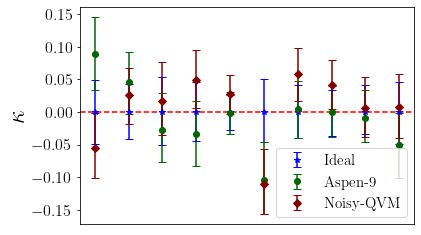

In [47]:
quant = 'k'
# states = chosen_states
fth = np.array([states[i]['Theory'][quant]['val'] for i in range(len(states))])
fthci = np.array([states[i]['Theory'][quant]['ci'] for i in range(len(states))])

# f2q = np.array([states[i]['2q-qvm']['Result'][quant]['val'] for i in range(len(states))])
# f2qci = np.array([states[i]['2q-qvm']['Result'][quant]['ci'] for i in range(len(states))])

fnq = np.array([states[i]['noisy-2q-qvm']['Result'][quant]['val'] for i in range(len(states))])
fnqci = np.array([states[i]['noisy-2q-qvm']['Result'][quant]['ci'] for i in range(len(states))])

fas = np.array([states[i]['Aspen-9']['Result'][quant]['val'] for i in range(len(states))])
fasci = np.array([states[i]['Aspen-9']['Result'][quant]['ci'] for i in range(len(states))])
# fnq = np.array([states[i]['noisy-2q-qvm']['Result'][quant]['val'] for i in range(len(states))])
# fasci = np.array([states[i]['Aspen-9']['Result'][quant]['ci'] for i in range(len(states))])

x = np.arange(len(states))

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Helvetica"]})

plt.errorbar(x, fth, yerr=[fth-fthci[:,0], fthci[:,1]-fth], marker="*", ls="", capsize=4, label='Ideal', color='blue')
# plt.errorbar(x, f2q, yerr=[f2q-f2qci[:,0], f2qci[:,1]-f2q], marker="o", ls="", capsize=4)
plt.errorbar(x, fas, yerr=[fas-fasci[:,0], fasci[:,1]-fas], marker="o", ls="", capsize=4, label='Aspen-9', color='darkgreen')
plt.errorbar(x, fnq, yerr=[fnq-fnqci[:,0], fnqci[:,1]-fnq], marker="D", ls="", capsize=4, label='Noisy-QVM', color='maroon')
# plt.plot(x, fas, 'o', label='Aspen-9')
# plt.plot(x, fnq, 'o')


# plt.axhline(y=1, ls='dashed', color='red')
# plt.axhline(y=-1, ls='dashed', color='red')
plt.axhline(y=0, ls='dashed', color='red')

# plt.xlabel('Iterations', size=22)
plt.ylabel('$\kappa$', size=24)

plt.xticks([],size=16)
plt.yticks(size=16)

plt.legend(loc='lower right', fontsize=15)#, bbox_to_anchor=(1,1))

plt.savefig(f'{quant}_one_shot_latest_24_oct.pdf', bbox_inches='tight')

plt.show()

In [182]:
states[0]

{'State_params': [(2.330122754090235, 5.081175731474043),
  (1.8414099326149804, 0.12900512482079862)],
 'Theory': {'g12': {'val': 0.9927011093614654,
   'ci': [0.8660820800899925, 1.12930435952464]},
  'g23': {'val': 0.23678871277151303,
   'ci': [0.174455895670337, 0.29833712794742495]},
  'g31': {'val': 0.3605298840853403,
   'ci': [0.28671583340515816, 0.4363240285931435]},
  'f': {'val': 1.0085053255849705,
   'ci': [0.7842498935582382, 1.2718704026930259]},
  'k': {'val': 0.0005429000000000003, 'ci': [-0.0403, 0.0383]}},
 'Aspen-9': {'Clicks_1100': array(['10', '10', '10', ..., '00', '11', '00'], dtype='<U2'),
  'Counts_1100': Counter({'10': 7715, '00': 1730, '11': 452, '01': 103}),
  'Clicks_0110': array(['00', '10', '10', ..., '11', '10', '01'], dtype='<U2'),
  'Counts_0110': Counter({'00': 2511, '10': 1694, '11': 1936, '01': 3859}),
  'Clicks_1010': array(['00', '11', '00', ..., '01', '11', '10'], dtype='<U2'),
  'Counts_1010': Counter({'00': 2378, '11': 2362, '10': 1443, '01'

In [184]:
with open('States_used_in_manuscript_plots_19_oct.pkl', 'wb') as file:
    pickle.dump([good_qubits, states], file)

In [183]:
good_qubits

{'Edge': Edge(targets=(23, 24), type=None, dead=False, gates=[GateInfo(operator='CZ', parameters=[], arguments=['_', '_'], duration=200, fidelity=0.9762620340466897), GateInfo(operator='CPHASE', parameters=['theta'], arguments=['_', '_'], duration=200, fidelity=0.8943444553858335), GateInfo(operator='XY', parameters=['theta'], arguments=['_', '_'], duration=200, fidelity=0.9695186079385717)]),
 'Qubit1': Qubit(id=23, type=None, dead=False, gates=[MeasureInfo(operator='MEASURE', qubit=23, target='_', duration=2000, fidelity=0.9789999999999999), MeasureInfo(operator='MEASURE', qubit=23, target=None, duration=2000, fidelity=0.9789999999999999), GateInfo(operator='RZ', parameters=['_'], arguments=[23], duration=0.01, fidelity=1.0), GateInfo(operator='RX', parameters=[0.0], arguments=[23], duration=50, fidelity=1.0), GateInfo(operator='RX', parameters=[3.141592653589793], arguments=[23], duration=50, fidelity=0.9992947355694914), GateInfo(operator='RX', parameters=[-3.141592653589793], argu

In [2]:
with open('States_used_in_manuscript_plots_19_oct.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

In [3]:
good_qubits, states = loaded_data[0], loaded_data[1]

In [4]:
states[0]

{'State_params': [(2.330122754090235, 5.081175731474043),
  (1.8414099326149804, 0.12900512482079862)],
 'Theory': {'g12': {'val': 0.9927011093614654,
   'ci': [0.8660820800899925, 1.12930435952464]},
  'g23': {'val': 0.23678871277151303,
   'ci': [0.174455895670337, 0.29833712794742495]},
  'g31': {'val': 0.3605298840853403,
   'ci': [0.28671583340515816, 0.4363240285931435]},
  'f': {'val': 1.0085053255849705,
   'ci': [0.7842498935582382, 1.2718704026930259]},
  'k': {'val': 0.0005429000000000003, 'ci': [-0.0403, 0.0383]}},
 'Aspen-9': {'Clicks_1100': array(['10', '10', '10', ..., '00', '11', '00'], dtype='<U2'),
  'Counts_1100': Counter({'10': 7715, '00': 1730, '11': 452, '01': 103}),
  'Clicks_0110': array(['00', '10', '10', ..., '11', '10', '01'], dtype='<U2'),
  'Counts_0110': Counter({'00': 2511, '10': 1694, '11': 1936, '01': 3859}),
  'Clicks_1010': array(['00', '11', '00', ..., '01', '11', '10'], dtype='<U2'),
  'Counts_1010': Counter({'00': 2378, '11': 2362, '10': 1443, '01'

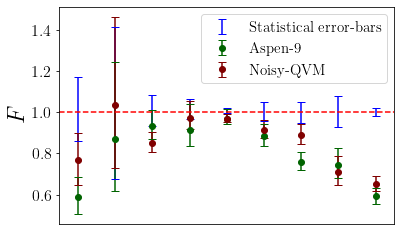

In [35]:
quant = 'f'
# states = chosen_states
fth = np.array([states[i]['Theory'][quant]['val'] for i in range(len(states))])
fthci = np.array([states[i]['Theory'][quant]['ci'] for i in range(len(states))])

# f2q = np.array([states[i]['2q-qvm']['Result'][quant]['val'] for i in range(len(states))])
# f2qci = np.array([states[i]['2q-qvm']['Result'][quant]['ci'] for i in range(len(states))])

fnq = np.array([states[i]['noisy-2q-qvm']['Result'][quant]['val'] for i in range(len(states))])
fnqci = np.array([states[i]['noisy-2q-qvm']['Result'][quant]['ci'] for i in range(len(states))])

fas = np.array([states[i]['Aspen-9']['Result'][quant]['val'] for i in range(len(states))])
# fnq = np.array([states[i]['noisy-2q-qvm']['Result'][quant]['val'] for i in range(len(states))])
fasci = np.array([states[i]['Aspen-9']['Result'][quant]['ci'] for i in range(len(states))])

x = np.arange(len(states))

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Helvetica"]})

plt.errorbar(x, fth, yerr=[fth-fthci[:,0], fthci[:,1]-fth], marker="", ls="", capsize=4, label='Statistical error-bars', color='blue')
# plt.errorbar(x, f2q, yerr=[f2q-f2qci[:,0], f2qci[:,1]-f2q], marker="o", ls="", capsize=4)
plt.errorbar(x, fas, yerr=[fas-fasci[:,0], fasci[:,1]-fas], marker="o", ls="", capsize=4, label='Aspen-9', color='darkgreen')
plt.errorbar(x, fnq, yerr=[fnq-fnqci[:,0], fnqci[:,1]-fnq], marker="o", ls="", capsize=4, label='Noisy-QVM', color='maroon')
# plt.plot(x, fas, 'o', label='Aspen-9')
# plt.plot(x, fnq, 'o')


plt.axhline(y=1, ls='dashed', color='red')
# plt.axhline(y=-1, ls='dashed', color='red')
# plt.axhline(y=0, ls='dashed', color='red')

# plt.xlabel('Iterations', size=22)
plt.ylabel('$F$', size=24)

# plt.xticks(size=16)
plt.xticks([])
plt.yticks(size=16)

plt.xlim([0.5,9.5])

plt.legend(loc='upper right', fontsize=15)#, bbox_to_anchor=(1,1))

# plt.savefig('f_one_shot_latest_21_oct.pdf', bbox_inches='tight')

# plt.show()

In [39]:
states[0]

{'State_params': [(2.330122754090235, 5.081175731474043),
  (1.8414099326149804, 0.12900512482079862)],
 'Theory': {'g12': {'val': 0.9928516034069315,
   'ci': [0.8173657657387472, 1.1800682665817028]},
  'g23': {'val': 0.2371864793418791,
   'ci': [0.1632692476134432, 0.31627472785479016]},
  'g31': {'val': 0.36144763372542227,
   'ci': [0.262689216358827, 0.4653383834432615]},
  'f': {'val': 1.0088539733637945,
   'ci': [0.7223224310825559, 1.379182767595623]},
  'k': {'val': -0.0006071000000000008, 'ci': [-0.0486, 0.0485]}},
 'Aspen-9': {'Clicks_1100': array(['10', '10', '10', ..., '00', '11', '00'], dtype='<U2'),
  'Counts_1100': Counter({'10': 7715, '00': 1730, '11': 452, '01': 103}),
  'Clicks_0110': array(['00', '10', '10', ..., '11', '10', '01'], dtype='<U2'),
  'Counts_0110': Counter({'00': 2511, '10': 1694, '11': 1936, '01': 3859}),
  'Clicks_1010': array(['00', '11', '00', ..., '01', '11', '10'], dtype='<U2'),
  'Counts_1010': Counter({'00': 2378, '11': 2362, '10': 1443, '01